Reading the "Reducing the Dimensionality of data with neural networks" paper by G. E. Hinton* and R. R. Salakhutdinov - https://www.cs.toronto.edu/~hinton/absps/science.pdf

Dimensionality reduction is the process of transforming data from a high dimensional space to a lower dimensional space (3D to 2D) while preserving as much information as possible during the reduction. It is useful because working with high dimensional data has some disadvantages (https://en.wikipedia.org/wiki/Curse_of_dimensionality) - more data is needed and organizing it is generally harder.

# Loading MNIST

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                               shuffle=True, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                              shuffle=True, num_workers=2)

/home/petko/projects/ai-notebooks/env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Visualizing an image from MNIST

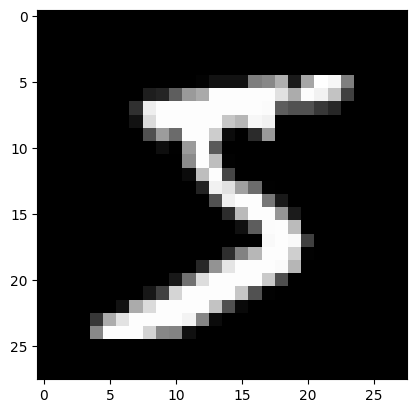

In [3]:
def show_image(image):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()
    
x = train_dataloader.dataset[0][0]

show_image(x)

There are a few methods for reducing the dimensionality - heatmaps, t-SNE, Multi-Dimensional Scaling, etc. A pretty simple and standard way of reducing the dimensionality is a method called Principal Component Analysis (PCA):

# Applying Principal Component Analysis (PCA):

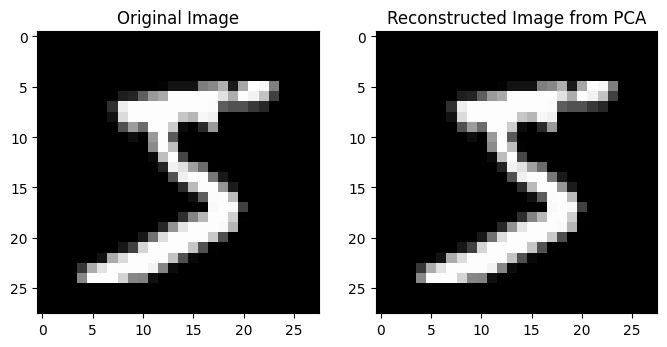

In [4]:
x_flattened = x.view(-1)

mean_x = torch.mean(x_flattened)

# Compute the covariance matrix
centered_image = x_flattened - mean_x
covariance_matrix = torch.mm(centered_image.unsqueeze(1), centered_image.unsqueeze(0)) / (x_flattened.numel() - 1)

# Compute the eigenvectors using SVD
_, s, v = torch.svd(covariance_matrix)

# Project the data onto the principal components
num_components = 10  # You can choose any desired number of principal components
principal_components = v[:, :num_components].t()  # Transpose for proper matrix multiplication
projected_data = torch.mm(centered_image.unsqueeze(0), principal_components.t())

# Reconstruct the data from the principal components
reconstructed_data = torch.mm(projected_data, principal_components) + mean_x.view(1, -1)

# Reshape the reconstructed data back to the original image size
reconstructed_image = reconstructed_data.view(x.size())

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.squeeze(), cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image.squeeze().detach(), cmap='gray')
plt.title('Reconstructed Image from PCA')
plt.show()

# Using Autoencoder for dimensionality reduction

### Naive Deep Autoencoder

In [5]:
from torchvision.utils import make_grid

def display_output(v0, vk, dim1=28, dim2=28, v0_fname=None, vk_fname=None):
    print("Original (top) and Reconstructed (bottom)")
    img = make_grid(v0.view(v0.shape[0], 1, dim1, dim2).data)
    npimg = np.transpose(img.detach().numpy(), (1, 2, 0))
    plt.imshow(npimg)
    if v0_fname is not None:
        plt.savefig(v0_fname)
    plt.show()
    img = make_grid(vk.view(vk.shape[0], 1, dim1, dim2).data)
    npimg = np.transpose(img.detach().numpy(), (1, 2, 0))
    plt.imshow(npimg)
    if vk_fname is not None:
        plt.savefig(vk_fname)    
    plt.show()

Epoch 0: 0.0650521535227802
Epoch 1: 0.049605703382476815
Epoch 2: 0.04224884425843957
Epoch 3: 0.03983201993220269
Epoch 4: 0.03853596479637918
Epoch 5: 0.037617168720883096
Epoch 6: 0.0369585348662537
Epoch 7: 0.036448783187596784
Epoch 8: 0.036077329281296554
Epoch 9: 0.03565767165154282
Original (top) and Reconstructed (bottom)


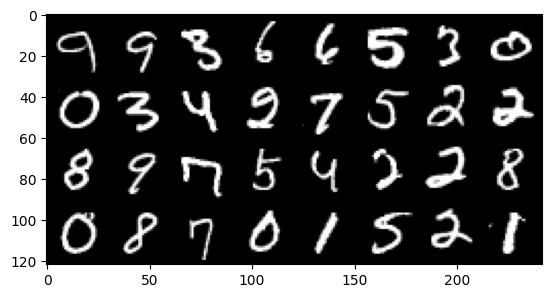

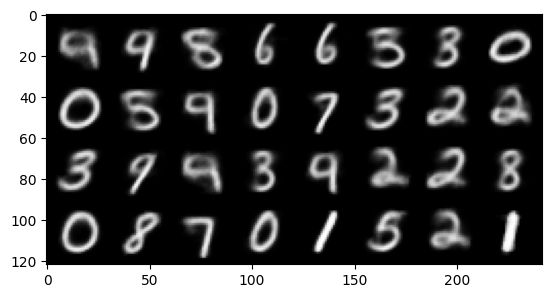

In [6]:
import os
import sys

module_path = os.path.abspath('.')
if module_path not in sys.path:
    sys.path.append(module_path)

from restricted_boltzmann_machine import RestrictedBoltzmannMachine
from deep_autoencoder import NaiveDeepAutoencoder
from torch import nn
from torch import optim

pixels = 784

def flatten_input(dataloader):
    flat_input = []
    labels = []
    for features, targets in dataloader:
        flat_input.append(features.view(-1, pixels).detach().numpy())
        labels.append(targets.detach().numpy())
    return np.concatenate(flat_input), np.concatenate(labels)


flat_train_input, train_labels = flatten_input(train_dataloader)
flat_test_input, test_labels = flatten_input(test_dataloader)
train_dataloader_flat = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    torch.Tensor(flat_train_input)), batch_size=64, shuffle=False)

learning_rate = 1e-3
naive_deep_autoencoder = NaiveDeepAutoencoder([784, 1000, 500, 250, 2])
loss = nn.MSELoss()
optimizer = optim.Adam(naive_deep_autoencoder.parameters(), learning_rate)
epochs = 10

running_loss = float("inf")
for epoch in range(epochs):
    losses = []
    for i, data_list in enumerate(train_dataloader_flat):
      data = data_list[0]
      v_pred = naive_deep_autoencoder(data)
      batch_loss = loss(data, v_pred)
      losses.append(batch_loss.item())
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
    running_loss = np.mean(losses)
    print(f"Epoch {epoch}: {running_loss}")
    if epoch % 10 == 9:
      display_output(data, v_pred, v0_fname="./images/original_digits.png", vk_fname="./images/reconstructed_digits_naive_dae.png")


We can see that the naive implementation of the autoencoder compresses the data but a lot of information is lost in the process.

### Restricted Boltzmann Machine

In [7]:
hidden_dimensions = [
    {
        "hidden_dim": 1000, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 28, 
        "display_dim2": 28, 
        "use_gaussian": False
    }, 
    {
        "hidden_dim": 500, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 25, 
        "display_dim2": 40, 
        "use_gaussian": False
    },
    {
        "hidden_dim": 250, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 25, 
        "display_dim2": 20, 
        "use_gaussian": False
    },
    {
        "hidden_dim": 2, 
        "num_epochs": 30, 
        "learning_rate": 0.001,
        "display_dim1": 25, 
        "display_dim2": 10, 
        "use_gaussian": True
    }
]

In [8]:
import torch

module_path = os.path.abspath('.')
if module_path not in sys.path:
    sys.path.append(module_path)

from deep_autoencoder import NaiveDeepAutoencoder
from restricted_boltzmann_machine import RestrictedBoltzmannMachine

def train_restricted_boltzmann_machine(train_dl, visible_dim, hidden_dim, k, num_epochs, lr, use_gaussian=False):
    restricted_boltzmann_machine = RestrictedBoltzmannMachine(visible_dim=visible_dim, hidden_dim=hidden_dim, gaussian_hidden_distribution=use_gaussian)
    loss = torch.nn.MSELoss()

    for epoch in range(num_epochs):
        train_loss = 0
        for i, data_list in enumerate(train_dl):
            sample_data = data_list[0]
            v0, pvk = sample_data, sample_data
            
            # Gibbs sampling
            for i in range(k):
                _, hk = restricted_boltzmann_machine.sample_h(pvk)
                pvk = restricted_boltzmann_machine.sample_v(hk)
            
            ph0, _ = restricted_boltzmann_machine.sample_h(v0)
            phk, _ = restricted_boltzmann_machine.sample_h(pvk)
            
            restricted_boltzmann_machine.update_weights(v0, pvk, ph0, phk, lr, 
                               momentum_coef=0.5 if epoch < 5 else 0.9, 
                               weight_decay=2e-4, 
                               batch_size=sample_data.shape[0])
            
            train_loss += loss(v0, pvk)
        
        print(f"Epoch {epoch}: {train_loss/len(train_dl)}")
    return restricted_boltzmann_machine, v0, pvk

784 to 1000
Epoch 0: 0.015288209542632103
Epoch 1: 0.01041732169687748
Epoch 2: 0.009744495153427124
Epoch 3: 0.009395561181008816
Epoch 4: 0.00917996745556593
Epoch 5: 0.010008209384977818
Epoch 6: 0.009297795593738556
Epoch 7: 0.008988926187157631
Epoch 8: 0.008815598674118519
Epoch 9: 0.008651701733469963
Original (top) and Reconstructed (bottom)


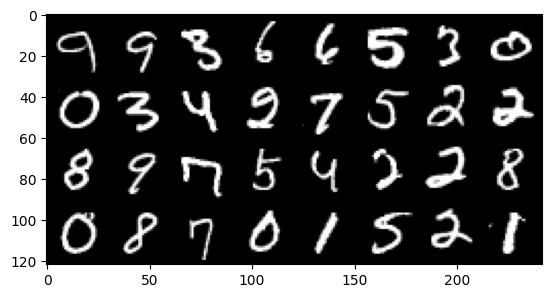

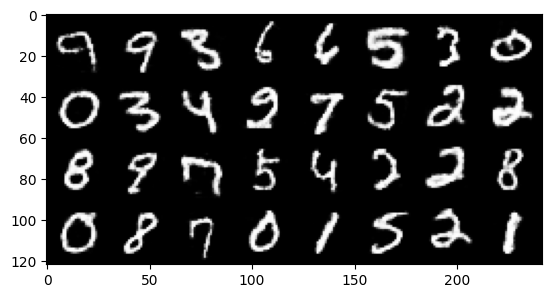

1000 to 500
Epoch 0: 0.017226645722985268
Epoch 1: 0.010838843882083893
Epoch 2: 0.009660409763455391
Epoch 3: 0.008856748230755329
Epoch 4: 0.008247670717537403
Epoch 5: 0.007750059012323618
Epoch 6: 0.006608618889003992
Epoch 7: 0.006119267083704472
Epoch 8: 0.005901055410504341
Epoch 9: 0.005792874377220869
Original (top) and Reconstructed (bottom)


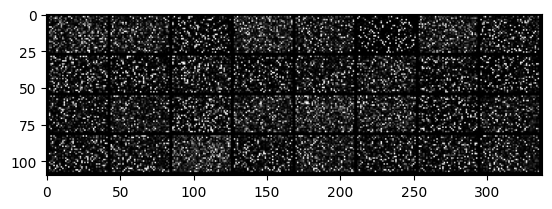

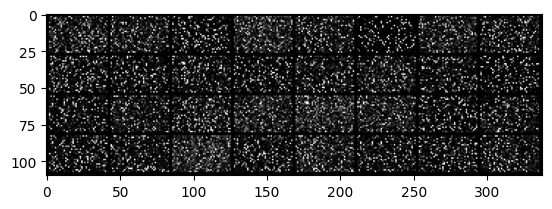

500 to 250
Epoch 0: 0.0220284853130579
Epoch 1: 0.013688212260603905
Epoch 2: 0.012511997483670712
Epoch 3: 0.01194137055426836
Epoch 4: 0.011554475873708725
Epoch 5: 0.01197481993585825
Epoch 6: 0.011194385588169098
Epoch 7: 0.010774986818432808
Epoch 8: 0.010556818917393684
Epoch 9: 0.010395070537924767
Original (top) and Reconstructed (bottom)


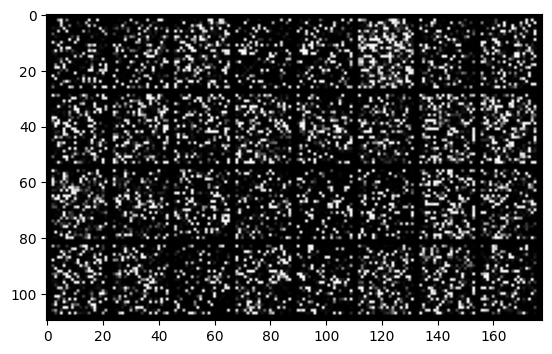

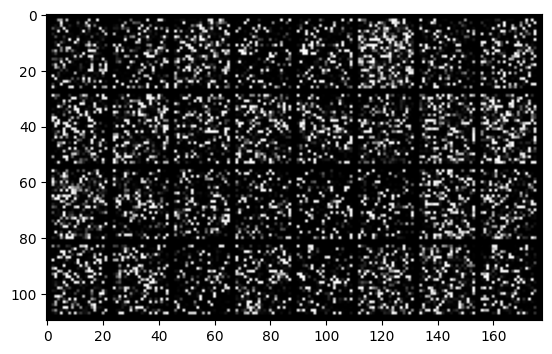

250 to 2
Epoch 0: 0.1627013087272644
Epoch 1: 0.14430172741413116
Epoch 2: 0.13873854279518127
Epoch 3: 0.13475221395492554
Epoch 4: 0.1325794756412506
Epoch 5: 0.13044698536396027
Epoch 6: 0.12953966856002808
Epoch 7: 0.12940914928913116
Epoch 8: 0.12938614189624786
Epoch 9: 0.12936317920684814
Epoch 10: 0.12936201691627502
Epoch 11: 0.12936367094516754
Epoch 12: 0.12935857474803925
Epoch 13: 0.129363015294075
Epoch 14: 0.12935873866081238
Epoch 15: 0.1293679177761078
Epoch 16: 0.129354327917099
Epoch 17: 0.1293562799692154
Epoch 18: 0.12935172021389008
Epoch 19: 0.1293523907661438
Epoch 20: 0.12934108078479767
Epoch 21: 0.12934771180152893
Epoch 22: 0.1293376088142395
Epoch 23: 0.1293480098247528
Epoch 24: 0.129327654838562
Epoch 25: 0.12935949862003326
Epoch 26: 0.1293567717075348
Epoch 27: 0.1293502002954483
Epoch 28: 0.12934845685958862
Epoch 29: 0.12935148179531097
Original (top) and Reconstructed (bottom)


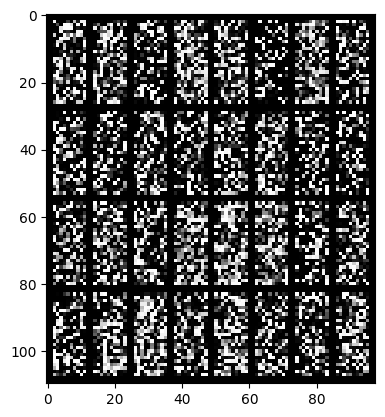

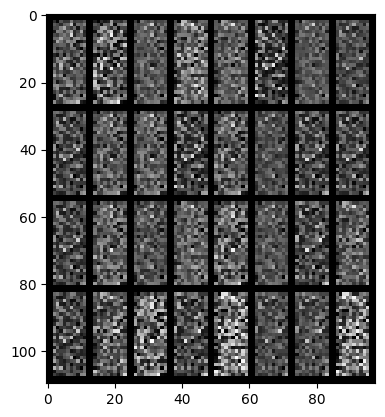

In [9]:
new_train_dataloader = train_dataloader_flat

visible_dim = pixels
hidden_dim = None
models = []
for configs in hidden_dimensions:
    hidden_dim = configs["hidden_dim"]
    num_epochs = configs["num_epochs"]
    lr = configs["learning_rate"]
    d1 = configs["display_dim1"]
    d2 = configs["display_dim2"]
    use_gaussian = configs["use_gaussian"]
    
    print(f"{visible_dim} to {hidden_dim}")
    model, v, v_pred = train_restricted_boltzmann_machine(new_train_dataloader, visible_dim, hidden_dim, k=1, num_epochs=num_epochs, lr=lr, use_gaussian=use_gaussian)
    models.append(model)
    
    display_output(v, v_pred, d1, d2)

    new_data = []
    for data_list in new_train_dataloader:
        p = model.sample_h(data_list[0])[0]
        new_data.append(p.detach().numpy())
    new_input = np.concatenate(new_data)
    new_train_dataloader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.Tensor(new_input)), 
        batch_size=64, 
        shuffle=False
    )
    
    visible_dim = hidden_dim

### Fine-tune Deep Autoencoder from Restricted Boltzmann Machine

Epoch 0: 0.04582358384405626
Epoch 1: 0.039613704429442946
Epoch 2: 0.03780340965686322
Epoch 3: 0.03678719123908833
Epoch 4: 0.03594012901997134
Epoch 5: 0.035470192243200124
Epoch 6: 0.03500631746691046
Epoch 7: 0.03464489558469385
Epoch 8: 0.03447663494105786
Epoch 9: 0.03403353930584022
Original (top) and Reconstructed (bottom)


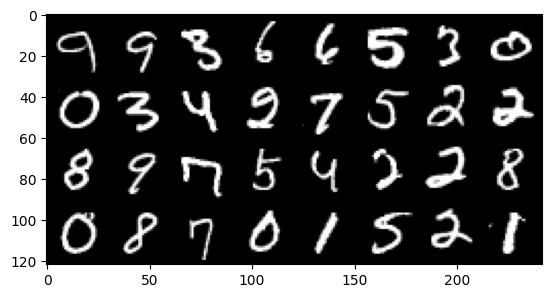

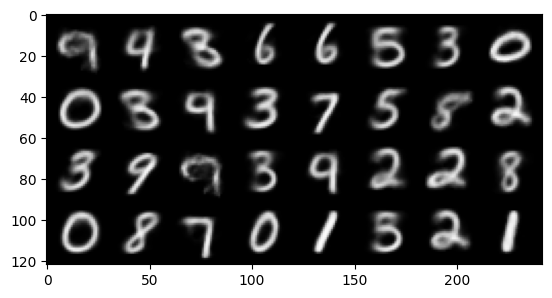

Epoch 10: 0.03368481454540735
Epoch 11: 0.033404189664354204
Epoch 12: 0.03354992978433683
Epoch 13: 0.033243003783862725
Epoch 14: 0.03289954162744889
Epoch 15: 0.03266864569226244
Epoch 16: 0.03258709743547478
Epoch 17: 0.03251984479950308
Epoch 18: 0.03231445907045211
Epoch 19: 0.03208861301448553
Original (top) and Reconstructed (bottom)


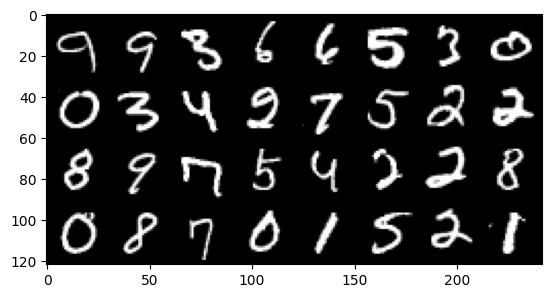

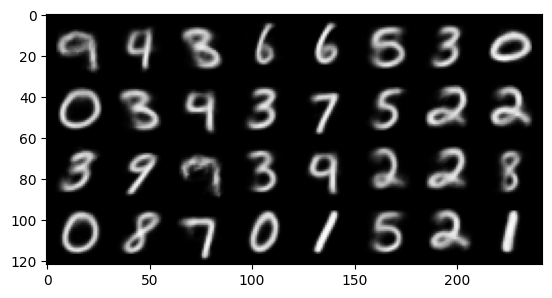

Epoch 20: 0.03200785024985194
Epoch 21: 0.031962416674902065
Epoch 22: 0.031822003400338486
Epoch 23: 0.03191432142967799
Epoch 24: 0.03175090726361727
Epoch 25: 0.03154744069848551
Epoch 26: 0.03158972003082159
Epoch 27: 0.03137170194761395
Epoch 28: 0.031244747370465606
Epoch 29: 0.03121867101750712
Original (top) and Reconstructed (bottom)


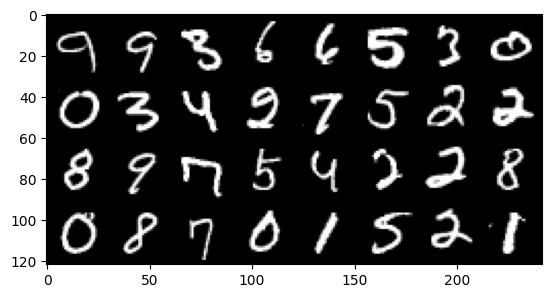

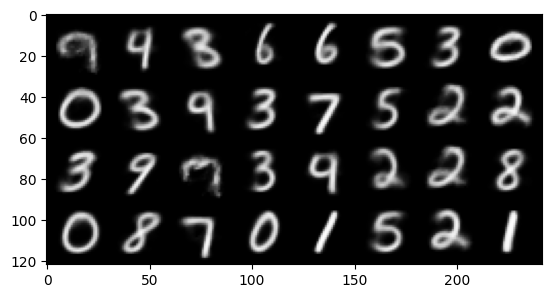

Epoch 30: 0.0311765940006036
Epoch 31: 0.031071760546741708
Epoch 32: 0.030895511119334557
Epoch 33: 0.030728857058769606
Epoch 34: 0.030623557119529004
Epoch 35: 0.03069952938721569
Epoch 36: 0.03068480356884346
Epoch 37: 0.030559346647754407
Epoch 38: 0.030519316900275283
Epoch 39: 0.030525917018543302
Original (top) and Reconstructed (bottom)


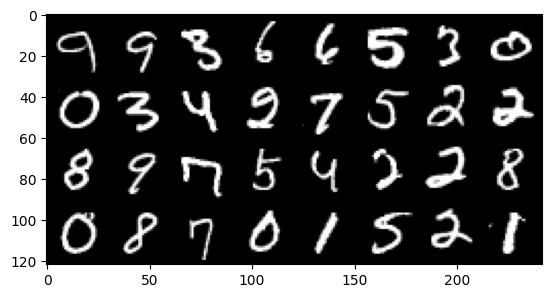

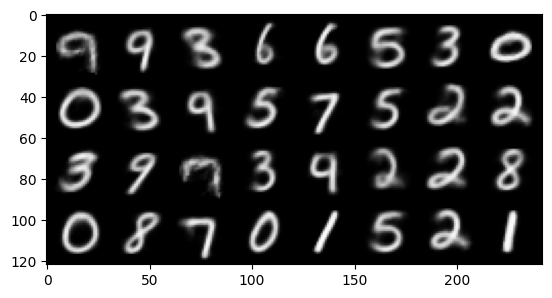

Epoch 40: 0.030473060747072386
Epoch 41: 0.03046371645208742
Epoch 42: 0.030261056177985312
Epoch 43: 0.030404068767897356
Epoch 44: 0.030522293200704462
Epoch 45: 0.0301421067194898
Epoch 46: 0.03019690020347455
Epoch 47: 0.0300778797142573
Epoch 48: 0.029982483898128656
Epoch 49: 0.029969302675267782
Original (top) and Reconstructed (bottom)


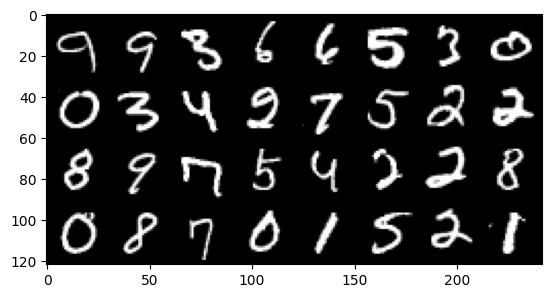

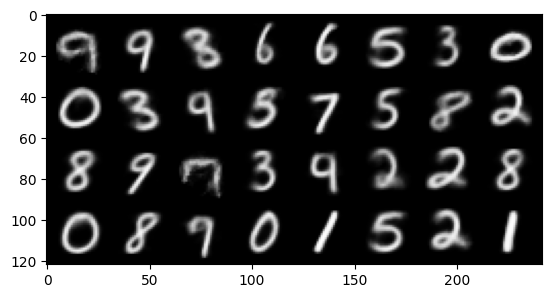

In [10]:
from deep_autoencoder import DeepAutoencoder

learning_rate = 1e-3
deep_autoencoder = DeepAutoencoder(models)
loss = nn.MSELoss()
optimizer = optim.Adam(deep_autoencoder.parameters(), learning_rate)
epochs = 50

for epoch in range(epochs):
    losses = []
    for i, data_list in enumerate(train_dataloader_flat): 
        data = data_list[0]
        v_pred = deep_autoencoder(data)
        batch_loss = loss(data, v_pred)
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    running_loss = np.mean(losses)
    print(f"Epoch {epoch}: {running_loss}")
    if epoch % 10 == 9:
        display_output(data, v_pred, v0_fname="./images/original_digits.png", vk_fname="./images/reconstructed_digits_dae.png")

The fine tuned autoencoder achieves better results than the naive implementation.